In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from biosppy.signals import ecg
import os
import neurokit as nk

In [2]:
datetime.datetime.fromtimestamp(1527108380).strftime("%Y-%m-%d %H:%M:%S")

'2018-05-23 16:46:20'

# Read ECG data

In [11]:
ecg_data_file = 'D:\data\ibeat\eplab\Subject42_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')

#ecg_data.columns
#only remains 'section', 'utc', 'utc_adjusted', 'date', 'II' for now.

ecg_data = ecg_data.drop(columns = ['ABL', 'ABL d', 'CS 1,2', 'CS 3,4', 'CS 5,6', 'CS 7,8', 'CS 9,10', 
        'Duo 1,2', 'Duo 11,12', 'Duo 13,14', 'Duo 15,16', 'Duo 17,18',
       'Duo 19,20', 'Duo 3,4', 'Duo 5,6', 'Duo 7,8', 'Duo 9,10', 'HIS d',
       'HIS m', 'HIS p', 'HRA', 'HRA d', 'I', 'III', 'RVa', 'RVa d',
       'Spiral 11,12', 'Spiral 13,14', 'Spiral 7,8', 'Spiral 9.10',
       'Spirlal 5,6', 'Stim 1', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'aVF',
       'aVL', 'aVR'])

# UTC to datetime (patient No. 42-51 checked) 

In [4]:
def adj(i):
    date = datetime.datetime.fromtimestamp(i).strftime("%Y-%m-%d %H:%M:%S")
    return date
ecg_data['date']=ecg_data['utc_adjusted'].apply(adj)
ecg_data.head(2)

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,utc,section,utc_adjusted,date
0,0.043,0.030,0.09,-0.143,-0.022,0.090,0.193,0.1,0.118,0.045,0.128,0.03,1.526570e+09,0.0,1.526570e+09,2018-05-17 11:19:12
1,0.037,0.028,0.09,-0.147,-0.020,0.088,0.198,0.1,0.120,0.045,0.128,0.03,1.526570e+09,0.0,1.526570e+09,2018-05-17 11:19:12


In [10]:
# end time
ecg_data.tail(2)

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,utc,section,utc_adjusted,date
15560702,-0.067,-0.093,0.011,0.048,-0.044,-0.030,0.063,-0.020,-0.017,-0.067,-0.042,-0.067,1.526593e+09,5.0,1.526593e+09,2018-05-17 17:35:25
15560703,-0.072,-0.093,0.013,0.048,-0.041,-0.033,0.066,-0.022,-0.018,-0.068,-0.043,-0.066,1.526593e+09,5.0,1.526593e+09,2018-05-17 17:35:25


In [6]:
#store the datetime column to 
#ecg_data.to_hdf('D:\data\ibeat\eplab\Subject66_data.hdf',key = 'ecg_data')

# Batch processing to transfer the utc to date

os.chdir('D:\data\ibeat\eplab')
file_name = os.listdir('D:\data\ibeat\eplab')
for file in file_name:
    ecg_data_file = 'D:\data\ibeat\eplab'
    ecg_data = pd.read_hdf(ecg_data_file, 'eplab')

# Analysis and plot  of ECG signals

In [10]:
#cut ecg data
ecg_data = ecg_data[(ecg_data['utc_adjusted']> 1527108380) & (ecg_data['utc_adjusted']<1527108473)]

In [3]:
## Run ECG Analysis on chunks:
ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]
    
    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 4 chunks


C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index

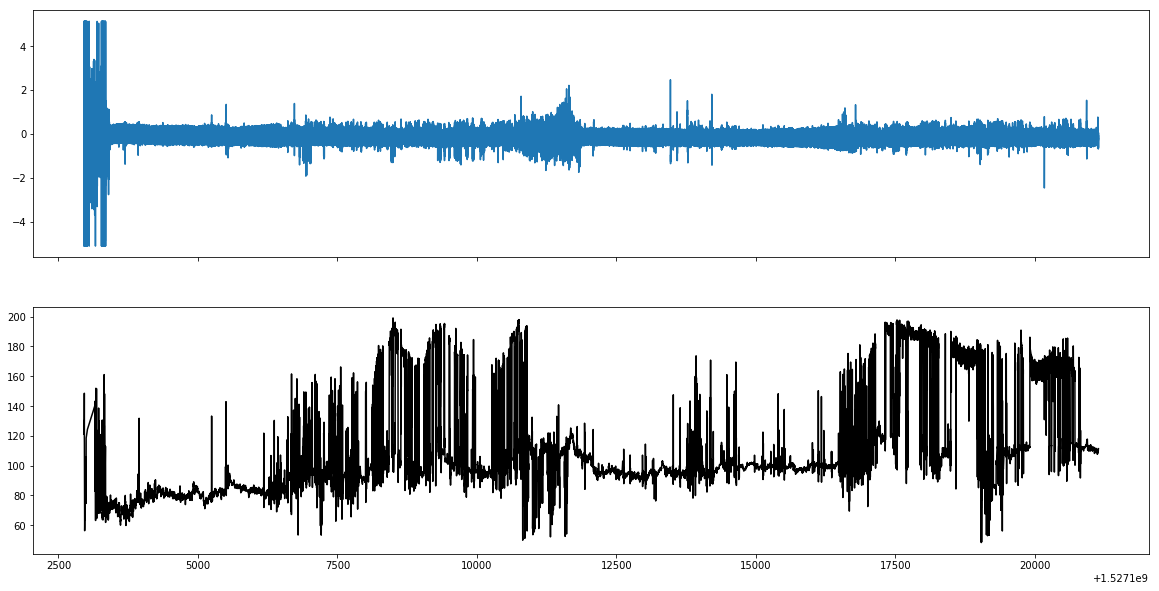

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

# Raw ECG Signal
ax[0].plot(ecg_data.utc_adjusted, ecg_data.II)

ax[1].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate')
# ax[-1].set_xlim([ecg_data.utc_adjusted.min(), ecg_data.utc_adjusted.max()])

# Using neurokit.py to analyze the data (RR intervals)

In [5]:
ecg_sig = ecg_data.II
processed_ecg = nk.ecg_process(ecg_sig, rsp=None, sampling_rate=976.942)
rpeaks = processed_ecg['ECG']['R_Peaks'].tolist()
HR = processed_ecg['df']['Heart_Rate'].tolist()

KeyboardInterrupt: 

In [ ]:
rrinterval = []
for i in range(len(rpeaks)-1):
    rrinterval.append((rpeaks[i+1]-rpeaks[i])/976.942)
del(rrinterval[0])
rrinterval[0:5]

# calculate heart rate using rr intervals to examine its accuracy 

In [ ]:
hr = []
for i in range(len(rrinterval)):
    hr.append(60/rrinterval[i])
hr[0:5]

In [ ]:
fig, ax = plt.subplots(4, 1, sharex=False, figsize=(20, 10))
threshold = [0.6] * len(rrinterval)
# Raw ECG Signal
ax[0].plot(rrinterval)
ax[0].plot(threshold, c='r')
ax[0].set_title('RR interval and threshold')
ax[1].plot(hr)
ax[1].set_ylim([80,200])
ax[1].set_title('HR calculated by RR')
ax[2].plot(HR)
ax[2].set_title('HR calculated by Neurokit')
ax[3].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate)
ax[3].set_title('HR calculated by Biosppy')

# OCR on PDF files

https://pythontips.com/2016/02/25/ocr-on-pdf-files-using-python/